# IMPORT

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import time
from shapely.geometry import box,LineString,Point,MultiPoint,MultiLineString,MultiPolygon,Polygon
from shapely.ops import unary_union
import socket
from collections import defaultdict
current_dir = os.path.join(os.getcwd()) 
mother_path = os.path.abspath(os.path.join(current_dir, os.pardir))
print('mother_path:', mother_path)
sys.path.append(os.path.join(mother_path, 'PreProcessing'))
sys.path.append(os.path.join(mother_path))
from FittingProcedures import *
from plot import *
from Potential import *
from Grid import *
from PreprocessingObj import *
from ODfromfma import *
import time
from GeometrySphere import *
from Polycentrism import *
#import rustworkx as rw
import ast
## BASIC PARAMS
plt.rcParams.update({
    "text.usetex": False,
})

if socket.gethostname()=='artemis.ist.berkeley.edu':
    TRAFFIC_DIR = '/home/alberto/LPSim/traffic_phase_transition'
else:
    TRAFFIC_DIR = os.getenv('TRAFFIC_DIR')
name = 'BOS'
grid_size = 0.02
hexagon_resolution = 8
dir_grid = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))

## BASIC NEEDED OBJECTS
SFO_obj = GeometricalSettingsSpatialPartition(name,TRAFFIC_DIR)
bbox = SFO_obj.bounding_box
minx, miny, maxx, maxy = bbox
dir_geometries = os.path.join(TRAFFIC_DIR,'data','carto','{0}'.format(name))
grid = GetGrid(grid_size,SFO_obj.bounding_box,'EPSG:4326',dir_geometries)
df_distance,FoundDistMat = GetDirectionMatrix(dir_geometries,grid_size)
Tij = GetODGrid(dir_geometries,str(grid_size))
lattice = nx.read_graphml(os.path.join(dir_grid,"centroid_lattice.graphml"))
#VectorField = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/VectorField.csv')
#Potential = pd.read_csv('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/PotentialDataFrame.csv')

# GET POTENTIAL AND VECTOR FIELD
VectorField = GetVectorField(Tij,df_distance)
VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))
lattice = GetPotentialLattice(lattice,VectorField)
lattice = SmoothPotential(lattice)
PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)



mother_path: /home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts


/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:20: SyntaxWarning: invalid escape sequence '\D'
  '''
/home/aamad/anaconda3/envs/geostuff/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Initialize Grid: 0.02
ALREADY COMPUTED


In [2]:
#import swifter
# Assuming gdf_polygons and grid are GeoDataFrames
# gdf_polygons contains polygons of the geographic area
# grid contains polygons covering the bounding box taken from the unary union

# Perform a spatial join to get the boundary of gdf_polygons
boundary = gpd.overlay(SFO_obj.gdf_polygons, SFO_obj.gdf_polygons, how='union',keep_geom_type=False).unary_union
boundary = boundary.simplify(0.01)

if isinstance(boundary, Polygon):
    boundary_line = LineString(boundary.exterior.coords)
elif isinstance(boundary, MultiPolygon):
    exterior_coords = []
#    for i,polygon in boundary.geoms:
    polygon = boundary.geoms[0]
    exterior_coords.extend(polygon.exterior.coords)
    boundary_line = LineString(exterior_coords)
grid['position'] = grid.geometry.apply(lambda x: 'inside' if x.within(boundary) else ('edge' if x.touches(boundary) else 'outside'))
grid['relation_to_line'] = grid.geometry.apply(lambda poly: 'edge' if boundary_line.crosses(poly) else 'not_edge')

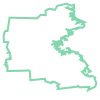

In [3]:
boundary_line

# COMPUTE CENTRALITY INDEX (PI)

Number of edge grids: 417
Number of grids in potential:  2704


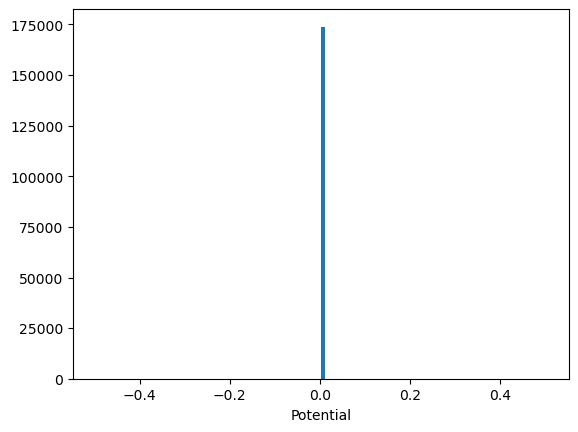

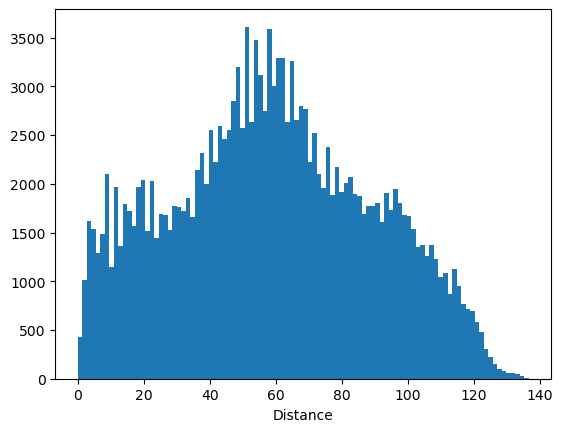

[0.00239808]
shape distance vector Vmax:  173889
shape potential vector Vmax:  173889
Vmax:  0.14124513114328682


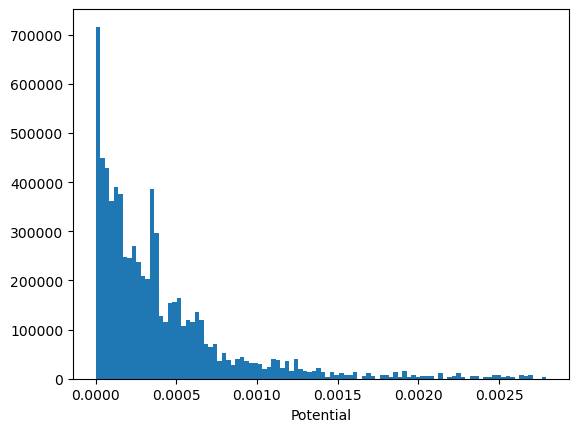

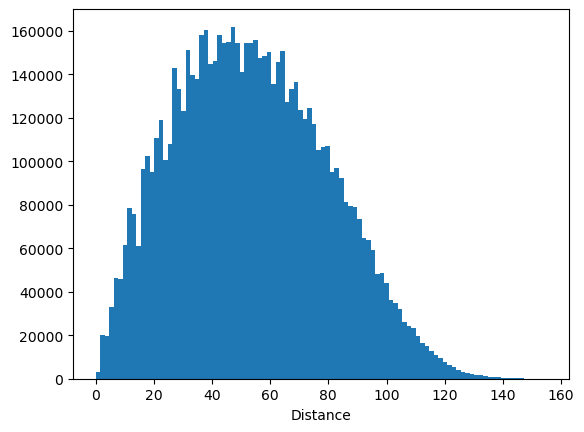

shape distance vector V:  7311616
shape potential vector V:  7311616
V:  0.019063197691180717
PI:  0.8650346561550362


In [ ]:
from tqdm import tqdm
from Polycentrism import *
SumPot = np.sum(PotentialDataframe['V_out']) 
NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]
IndexEdge = PotentialDataframe[PotentialDataframe['V_out']>0]['index'].values
print('Number of edge grids:',NumGridEdge)
print('Number of grids in potential: ',len(IndexEdge))
distance_vector,potential_vector = PrepareJitCompiledComputeV(df_distance,GetIndexEdgePolygon(grid),SumPot,NumGridEdge,PotentialDataframe,case = 'Vmax')
plt.hist(potential_vector,bins = 100)
plt.xlabel('Potential')
plt.show()
plt.hist(distance_vector,bins = 100)
plt.xlabel('Distance')
plt.show()
print(np.unique(potential_vector))
print('shape distance vector Vmax: ',len(distance_vector))
print('shape potential vector Vmax: ',len(potential_vector))
Vmax = ComputeJitV(distance_vector,potential_vector)
print('Vmax: ',Vmax)
distance_vector,potential_vector = PrepareJitCompiledComputeV(df_distance,IndexEdge,SumPot,NumGridEdge,PotentialDataframe,case = 'V')
plt.hist(potential_vector,bins = 100)
plt.xlabel('Potential')
plt.show()
plt.hist(distance_vector,bins = 100)
plt.xlabel('Distance')
plt.show()

print('shape distance vector V: ',len(distance_vector))
print('shape potential vector V: ',len(potential_vector))
V = ComputeJitV(distance_vector,potential_vector)
print('V: ',V)
PI = ComputePI(V,Vmax)
print('PI: ',PI)

In [ ]:
print('MaxV:',Vmax)
print('SumPot:',SumPot)
print('NumGridEdge:',NumGridEdge)
print('SumPot/MaxV:',SumPot/Vmax)


In [4]:
0.71*0.84

0.5963999999999999

# MODIFY POPULATION 

### PLOT OD

In [ ]:
import igraph as ig
import time
from matplotlib.cm import inferno
from matplotlib.colors import Normalize

# CREATE GRAPH 
ig_G = ig.Graph()
ig_G.add_vertices(grid['index'])
pos = [[row['centroidx'],row['centroidy']] for id,row in grid.iterrows()]
ig_G.vs["pos"] = pos
layout = pos
edges = [(row.origin, row.destination) for row in Tij.itertuples(index=False) if row.number_people>0]
edges_with_weights = [(row.origin, row.destination, row.number_people) for row in Tij.itertuples(index=False) if row.number_people > 0]
# Add edges to igraph graph with weights
ig_G.add_edges([(e[0], e[1]) for e in edges_with_weights])  # Add edges without weights first
ig_G.es["weights"] = [e[2] for e in edges_with_weights]  # Assign weights to edges

# DEFINE MAX/MIN WEIGHTS for CMAP
min_weight = min(ig_G.es["weights"])
max_weight = max(ig_G.es["weights"])
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in ig_G.es["weights"]]

# SELECT 5% NODES WITH HIGHER DEGREE
degrees = ig_G.degree()
sorted_nodes = sorted(range(len(degrees)), key=lambda x: degrees[x], reverse=True)
top_5_percent = int(len(degrees) * 0.001)
top_nodes = sorted_nodes[:top_5_percent]
selected_edges = [(edge.source, edge.target) for edge in ig_G.es if edge.source in top_nodes]
subgraph_edges = ig_G.subgraph_edges(selected_edges)

#BOUNDING BOX SELECTION
cmap = inferno
norm = Normalize(vmin=min_weight, vmax=max_weight)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in ig_G.es["weights"]]
bbox = SFO_obj.gdf_polygons.total_bounds
#layout_G = ig_G.layout(coords = )
# PLOT
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ig.plot(subgraph_edges, layout = ig_G.vs["pos"], bbox=(0,0,1000,1000), vertex_size=2, vertex_color='lightblue',
        edge_color=[(0, 0, 0, weight / max_weight) for weight in subgraph_edges.es["weights"]], target=ax)
#SFO_obj.gdf_polygons.plot(ax=ax, color='none', edgecolor='black')

#plt.gca().set_aspect('equal')  # Set aspect ratio to equal
#plt.gca().set_axis_off()  # Turn off axes
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#cbar = plt.colorbar(sm, ax=ax)
#cbar.set_label('Edge Weight')
#plt.title('Edges from Top 5% Nodes with Highest Degree')
plt.show()


# PLOT THE CIRCUITATION

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ast
def safe_literal_eval(s):
    if ',' not in s:
        s1 = s.split(' ')
        if len(s1)==2:
            return [float(s1[0].replace('[','')),float(s1[1].replace(']',''))]      # Add commas between elements
        elif len(s1)!=2:
            s1 = s.split('  ')
            if len(s1) ==2:
                return [float(s1[0].replace('[','')),float(s1[1].replace(']',''))]      # Add commas between elements
            elif len(s1)!=2:
                s1 = s.split('   ')
                return [float(s1[0].replace('[','')),float(s1[1].replace(']',''))]      # Add commas between elements
    else:
        try:
            return ast.literal_eval(s)
        except SyntaxError:
            # Handle SyntaxError here
            print("SyntaxError: Invalid syntax in the input string")
            return None

def GetCenterMapIdx(grid):
    mean_x = grid['geometry'].centroid.x.mean()
    mean_y = grid['geometry'].centroid.y.mean()
    # Create a Point geometry for the center of mass
    center_of_mass = Point(mean_x, mean_y)
    distances = grid['geometry'].centroid.distance(center_of_mass)
    # Find the index of the row with the minimum distance
    closest_row_index = distances.idxmin()
    print("Index of the row closest to the center of mass:")
    print(closest_row_index)
    return closest_row_index

def QuiverEdge(ax,coordinates,index2choose,color):
    for i in range(len(coordinates)-1):
        x1 = coordinates[i]
        x2 = coordinates[i+1] 
        if i in index2choose:
            ax.quiver(x1[0], x1[1],x2[0] - x1[0],x2[1] - x1[1], color=color, linewidth=2)


def CreateListIndicesSquareLoop(startIdx,n_rows):
    return [startIdx -1,startIdx,startIdx + n_rows,startIdx + n_rows -1]

def CreateClosedLoopSquare(grid,startIdx,n_rows,VectorField):
    indicesDF_loop = CreateListIndicesSquareLoop(startIdx,n_rows)
    LoopCircuit = []
    LoopVF = []
    for i in range(len(indicesDF_loop)-1):
        LoopCircuit.append(list(grid['geometry'][indicesDF_loop[i]].boundary.coords)[i:i+1])
        LoopVF.append(list(safe_literal_eval(VectorField['Ti'][indicesDF_loop[i]]))) 
    LoopVF.append(list(safe_literal_eval(VectorField['Ti'][indicesDF_loop[i+1]]))) 
    return LoopCircuit,LoopVF

def QuiverCircuitation(LoopCircuit,LoopVF,ax):
    Circuitation = 0
    for i in range(len(LoopCircuit)-1):
        x1 = LoopCircuit[i][0]
        x2 = LoopCircuit[i+1][0]
        vx = LoopVF[i][0]
        vy = LoopVF[i][1]
        print(x1,x2,vx,vy)
        Circuitation += (x2[0] - x1[0])*vx + (x2[1] - x1[1])*vy
        ax.quiver(x1[0], x1[1],x2[0] - x1[0],x2[1] - x1[1], color='red', linewidth=2)
        ax.quiver(x1[0], x1[1],vx,vy, color='yellow', linewidth=2)
    return Circuitation



closest_row_index = GetCenterMapIdx(grid)
## GET THE NUMBER OF ROW AND COLS FOR YOUR GRID (It depends on the resolution)
n_rows = 57
n_cols = 61

fig, ax = plt.subplots(figsize=(10, 10))
#indices = [True if (i>(closest_row_index -3) & i<(closest_row_index + 3)) or (i>(closest_row_index +n_rows-3) and i<(closest_row_index +n_rows + 3))   else False for i,row in SFO_obj.gdf_polygons.iterrows()]
#gdf_plot = SFO_obj.gdf_polygons.loc[indices] 
#grid_plot = grid.loc[indices]
SFO_obj.gdf_polygons.plot(ax = ax)
grid.plot(ax=ax, facecolor='none', edgecolor='black')  # Plot the grid without filling
LoopCircuit,LoopVF = CreateClosedLoopSquare(grid,closest_row_index,n_rows,VectorField)
Circuitation = QuiverCircuitation(LoopCircuit,LoopVF,ax)
print(Circuitation)
#loop_edges0 = grid['geometry'][closest_row_index -1].boundary
#loop_edges1 = grid['geometry'][closest_row_index].boundary
#loop_edges2 = grid['geometry'][closest_row_index + n_rows].boundary
#loop_edges3 = grid['geometry'][closest_row_index + n_rows -1].boundary
#coordinates0 = list(loop_edges0.coords)
#coordinates1 = list(loop_edges1.coords)
#coordinates2 = list(loop_edges2.coords)
#coordinates3 = list(loop_edges3.coords)
#QuiverEdge(ax,coordinates0,[0,1],'green')
#QuiverEdge(ax,coordinates1,[1,2],'red')
#QuiverEdge(ax,coordinates2,[2,3],'yellow')
#QuiverEdge(ax,coordinates3,[3,0],'orange')
    
plt.title('Loop with its Edges')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
print('Average Population in Inhabited grids: ',np.mean(grid['population'].loc[np.where(grid['population']>0)]))
print('Number of Inhabited grids: ',len(grid['population'].loc[np.where(grid['population']>0)]))
print('Number of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'].loc[np.where(grid['population']>0)])]))
print('Fraction of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'].loc[np.where(grid['population']>0)])])/len(grid['population'].loc[np.where(grid['population']>0)]))
print('Average Population in Non-Inhabited grids: ',np.mean(grid['population']))
print('Number of Non-Inhabited grids: ',len(grid['population']))
print('Number of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'])]))
print('Fraction of cells that have less then average population: ',len(grid['population'].loc[grid['population']>np.mean(grid['population'])])/len(grid['population']))
print('Fraction of Inhabited/Non-Inhabited grids: ',len(grid['population'].loc[np.where(grid['population']>0)])/len(grid['population']))
# CHOICE AREA TO STUDY: JUST POPULATED
RestrictedPop = grid['population'].loc[np.where(grid['population']>0)]
# MIN and MAX Pop -> to set the interval for the exponential distribution
MinPop = min(RestrictedPop)
MaxPop = max(RestrictedPop)
# Resolution 
bins = 500
print('Resolution in Population (number of people): ',(MaxPop - MinPop)/bins)
print('Minimum Population Considered: ',MinPop)
print('Maximum Population Considered: ',MaxPop)


Average Population in Inhabited grids:  1960.5355515759077
Number of Inhabited grids:  2319
Number of cells that have less then average population:  556
Fraction of cells that have less then average population:  0.2397585166019836
Average Population in Non-Inhabited grids:  1307.5875594203421
Number of Non-Inhabited grids:  3477
Number of cells that have less then average population:  834
Fraction of cells that have less then average population:  0.23986194995685936
Fraction of Inhabited/Non-Inhabited grids:  0.6669542709232097
Resolution in Population (number of people):  66.88890811188139
Minimum Population Considered:  5.0209312250844166e-05
Maximum Population Considered:  33444.454106150006


### Exponential Distribution Generation Points

In [ ]:
# Creation Exponential Distr
PopBins = np.linspace(MinPop,MaxPop,bins)
m0 = np.mean(RestrictedPop)
PopExpo =  np.exp(-PopBins/m0)/np.sum(np.exp(-PopBins/m0))
AverageExpo = np.sum(PopBins*PopExpo)
IdxBinMean = np.where(PopBins<AverageExpo)[0]
CumulativePopExpo = np.cumsum(PopExpo)
print('m0: ',m0)
print('Average Expo: ',AverageExpo)
print('m0 - AverageExpo: ',m0 - AverageExpo)
#print('Cumulative Population Expo: ',CumulativePopExpo)
print('Cumulative at Average: ',CumulativePopExpo[max(IdxBinMean)])


m0:  1960.5355515759077
Average Expo:  1927.2137944051556
m0 - AverageExpo:  33.32175717075211
Cumulative at Average:  0.6289414198712806


# Power Law Distribution Fitted Generation Points

In [ ]:
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitPlMass.json','r') as f:
    fitplM = json.load(f)
# Data
PopPlBins = np.linspace(MinPop,MaxPop,bins)
PopPl = 11*PopPlBins**(-1.83) 
#PopPl = fitplM['A']*PopPlBins**(fitplM['b']) 
PopPl = PopPl/np.sum(PopPl)
AveragePl = np.sum(PopPl*PopPlBins)
IdxBinsMeanData = min(np.where(PopPl<AveragePl)[0])
CumulativePopData = np.cumsum(PopPl)
print('Average Data: ',np.sum(PopPl*PopPlBins))
print('Teorethical Cumulative at average: ',1/(-1.83 + 1)*(max(PopPlBins)**(-1.83 + 2)-min(PopPlBins)**(-1.83 + 2)))
print('Cumulative at Average: ',CumulativePopData[IdxBinsMeanData])



Average Data:  5.0214110381853496e-05
Teorethical Cumulative at average:  -6.856486584558129
Cumulative at Average:  0.9999999999948642


# Data

In [ ]:
binsd = 40
PopData,PopDataBins = np.histogram(RestrictedPop,binsd)
#PopDataBins = np.array([PopDataBins[i] + PopDataBins[i + 1] for i in range(len(PopDataBins)-1)])
PopData = PopData/np.sum(PopData)
AverageData = np.sum(PopData*PopDataBins[:-1])
IdxBinsMeanData = max(np.where(PopData<AverageData)[0])
CumulativePopData = np.cumsum(PopData)
print('Average Data: ',AverageData)
print('Cumulative at Average: ',CumulativePopData[IdxBinsMeanData])


Average Data:  1590.738852438833
Cumulative at Average:  1.0


### Comparison Expo Data

In [ ]:
PopExpo_mesh, PopData_mesh = np.meshgrid(PopExpo, PopData/np.sum(PopData))
heatmap_data = PopExpo_mesh - PopData_mesh
X, Y = np.meshgrid(PopBins, PopDataBins)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='coolwarm', aspect='auto', origin='lower', extent=[PopBins[0], PopBins[-1], PopDataBins[0], PopDataBins[-1]])
plt.colorbar(label='Difference')

contour = plt.contour(X, Y, heatmap_data, levels=[0], colors='black', linewidths=2)
#plt.clabel(contour, inline=True, fontsize=10)
plt.xlabel('Population')
plt.ylabel('Population (Data)')
plt.title('exp(-Pop/m0)/m0 - Pdata, m0 = '.format(round(m0,2)))
plt.show()


fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(PopDataBins,PopData,label = 'Data')
ax.plot(PopBins,PopExpo,label = 'Expo')
ax.set_xlabel('Population')
ax.set_ylabel('pdf')
ax.set_yscale('log')
plt.show()



### Comparison PowerLaw Expo

In [ ]:
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(PopPlBins,np.cumsum(PopPl),label = 'Data')
ax.plot(PopBins,np.cumsum(PopExpo),label = 'Expo')
IdxChange = min(np.where(PopPl>PopExpo)[0])
ax.axvline(PopPlBins[IdxChange])
ax.text(PopPlBins[IdxChange] + 500, 0, f'P* = {PopPlBins[IdxChange]:.2f}', ha='right', va='bottom', color='black')
ax.set_xlabel('Population')
ax.set_ylabel('pdf')
plt.show()

fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(PopPlBins,PopPl,label = 'Data')
ax.plot(PopBins,PopExpo,label = 'Expo')
ax.axvline(PopPlBins[IdxChange])
ax.text(PopPlBins[IdxChange] + 500, 0, f'P* = {PopPlBins[IdxChange]:.2f}', ha='right', va='bottom', color='black')
ax.set_xlabel('Population')
ax.set_ylabel('pdf')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


# Modify polycenters


# PI

In [ ]:
from tqdm import tqdm
from Polycentrism import *
SumPot = np.sum(PotentialDataframe['V_out']) 
NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]
IndexEdge = PotentialDataframe[PotentialDataframe['V_out']>0]['index'].values
print('Number of edge grids:',NumGridEdge)
print('Number of grids in potential: ',len(IndexEdge))
distance_vector,potential_vector = PrepareJitCompiledComputeV(df_distance,GetIndexEdgePolygon(grid),SumPot,NumGridEdge,PotentialDataframe,case = 'Vmax')
print('shape distance vector Vmax: ',len(distance_vector))
print('shape potential vector Vmax: ',len(potential_vector))
Vmax = ComputeJitV(distance_vector,potential_vector)
print('Vmax: ',Vmax)
distance_vector,potential_vector = PrepareJitCompiledComputeV(df_distance,IndexEdge,SumPot,NumGridEdge,PotentialDataframe,case = 'V')
print('shape distance vector V: ',len(distance_vector))
print('shape potential vector V: ',len(potential_vector))
V = ComputeJitV(distance_vector,potential_vector)
print('V: ',V)
PI = ComputePI(V,Vmax)
print('PI: ',PI)

In [5]:
def polar_coordinates(point, center):
    y = point[1] - center[1]#ProjCoordsTangentSpace(center[0],center[1],point[0],point[1])
    x = point[0] - center[0]
    r = np.sqrt(x**2 + y**2)/1000
    # Calculate θ
    theta = np.arctan(y/x)
    
    # Adjust θ to be positive
#    theta = (theta + 2 * np.pi) % (2 * np.pi)
    # Round r and θ to the nearest steps
#    r = round(r / r_step) * r_step
#    theta = round(theta / theta_step) * theta_step
    return r, theta

population,centroidx,centroidy,index,filtered_grid = FilterPopulation(grid)
coords_center,_ = ExtractCenterByPopulation(grid)
#CenterMass = ComputeCM(grid,coords_center)

grid['is_populated'] = grid['population']>0
grid['coords'] = grid.apply(lambda x: ProjCoordsTangentSpace(x['centroidx'],x['centroidy'],coords_center[0],coords_center[1]),axis = 1)
grid['distance_from_center'] = grid.apply(lambda x: polar_coordinates(np.array([x['centroidx'],x['centroidy']]),np.array(x['coords']))[0],axis = 1)

##### TODO: Decide if the principal parameter that we change is either continuous as the fraction of mass per cell i or descrete as the number of centers that we change.
##### What is the map between one and the other?

In [19]:
def GenerateIndexCenters(grid,num_peaks):
    '''
        Generate random centers given number of them exponentially from the center.
    '''
    if 'is_populated' not in grid.columns:
        grid['is_populated'] = grid['population']>0
    if 'coords' not in grid.columns:
        grid['coords'] = grid.apply(lambda x: ProjCoordsTangentSpace(x['centroidx'],x['centroidy'],coords_center[0],coords_center[1]),axis = 1)
        grid['distance_from_center'] = grid.apply(lambda x: polar_coordinates(np.array([x['centroidx'],x['centroidy']]),np.array(x['coords']))[0],axis = 1)
    index_centers = []

    scale = np.mean(grid.loc[grid['is_populated']]['distance_from_center'])
    populated_grid = grid.loc[grid['is_populated']]
    # PICK RANDOMLY THE CENTERS (with exponentially decreasing probability in distance from center)
    random_values = np.random.exponential(scale,num_peaks)
    hist, bin_edges = np.histogram(populated_grid['distance_from_center'].to_numpy(), bins=30)
#    print(random_values)
    for rv in random_values:
        if rv > bin_edges[-1]:
            while(rv >= bin_edges[-1]):
                rv = np.random.exponential(scale)
#                print('extracting rv: ',rv)
                bin_index = np.digitize(rv, bin_edges)
#                print('bin index: ',bin_index)     
                filtered_grid = populated_grid[(populated_grid['distance_from_center'] >= bin_edges[bin_index - 1])] 
                filtered_grid = filtered_grid[filtered_grid['distance_from_center'] < bin_edges[bin_index]]   
                print('Distance from center extracted: ',rv,'Number of grids available: ',len(filtered_grid))
        else:
            bin_index = np.digitize(rv, bin_edges)
#            print('bin index: ',bin_index)     
            filtered_grid = populated_grid[(populated_grid['distance_from_center'] >= bin_edges[bin_index - 1])] 
            filtered_grid = filtered_grid[filtered_grid['distance_from_center'] < bin_edges[bin_index]]        
#            print('Length filtered grid: ',len(filtered_grid), ' rv: ',rv)
        if filtered_grid.shape[0] == 0:
            print('Empty bin')
        else:
            selected_row = filtered_grid.sample()
            # Step 6: Get the index of the selected row
            selected_index = selected_row['index'].values[0]
            print('Grid selected: ',selected_index)
            index_centers.append(selected_index)
    return index_centers

def SetCovariances(index_centers):
    '''
        Set the covariance matrix for each center.
        Distribute the same quantity of people for each center with different covariances.
    '''
    covariances = []
    for i in range(len(index_centers)):
        rvs = [[np.random.uniform(2,15),0],[0,np.random.uniform(2,15)]]
        covariances.append(rvs)
    return covariances

@numba.njit(['(float32[:], float32[:], float32,float32,float32,float32)'],parallel=True)
def GravitationalModel(population,df_distance,k,alpha,beta,d0):
#    print('k: ',k,' alpha: ',alpha,' beta: ',beta,' d0: ',d0)
#    print('<k*p>: ',np.mean(k*population))
#    print('<p**alpha>: ',np.mean(population**alpha))
#    print('<p**beta>: ',np.mean(population**beta))
#    print('<exp(-d/d0)>: ',np.mean(np.exp(df_distance*d0)))
#    print('<k*population**(alpha)*population**(beta)>: ',np.mean(k*np.tensordot(population**(alpha),population**(beta),axes = 0)))
    kMiMjedij = np.zeros(len(population)*len(population),dtype=np.float32)
    for i in range(len(population)):
        for j in range(len(population)):
            kMiMjedij[i*len(population) + j] += k*population[i]**(alpha)*population[j]**(beta)*np.exp(df_distance[i*len(population) + j]*d0)
#    kMiMjedij = [k*population[i]**(alpha)*population[j]**(beta)*np.exp(-df_distance[i*len(population) + j]/d0) for i in range(len(population)) for j in range(len(population))]
    return kMiMjedij


In [24]:
from ipfn import ipfn
'''
{'logk': 0.0003055803472447064, 'alpha': 0.0002546775749831938, 'gamma': -0.07627729954795813, '1/d0': 4.8774299414384545}
Number centers considered:  2
[ 3.37484752 51.76501691]
bin index:  2
Length filtered grid:  32  rv:  3.3748475174250743
bin index:  23
Length filtered grid:  60  rv:  51.76501690675754
New population:  574776957.9199114
k:  1.0003056270416752  alpha:  0.0002546775749831938  beta:  -0.07627729954795813  d0:  4.8774299414384545
<k*p>:  165358.83
<p**alpha>:  1.0017573
<p**beta>:  0.6491281
<exp(-d/d0)>:  0.010571069

'''

with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
print(fitGLM)
k = np.exp(fitGLM['logk'])
alpha =fitGLM['alpha']
beta = fitGLM['gamma']
d0 = fitGLM['1/d0']
list_peaks = [2,3,4,5,6,8,10]
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
total_population = np.sum(grid['population'])
total_flux = np.sum(Tij['number_people'])

for num_peaks in list_peaks:
    print('Number centers considered: ',num_peaks)
    index_centers = GenerateIndexCenters(grid,num_peaks)
    covariances = SetCovariances(index_centers)
    potential_values = np.zeros(len(grid))
    total_population_center = total_population/len(index_centers)
    new_population = np.ones(len(grid))
    centers = grid.loc[index_centers][['centroidx','centroidy']].to_numpy()
    count_center = 0
    for center in centers:
        for i in range(len(grid)):
            point = np.array([grid['centroidx'][i], grid['centroidy'][i]])
#            print('Coords Projected: ',ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))
#            print('norm: ',np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))**2)
#            print('covariance: ',covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2)
            if grid['is_populated'][i]:
                new_population[i] += total_population_center*np.exp(-(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2/(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))/2
            else:
                new_population[i] = 0
        count_center += 1
    print('New population: ',new_population.sum())
    # Store Data About Population and Fluxes
    InfoConfigurationPolicentricity[num_peaks]['grid'] = grid.copy()
    InfoConfigurationPolicentricity[num_peaks]['Tij'] = Tij.copy()
    # Normalize Population
    IPF = ipfn.ipfn(InfoConfigurationPolicentricity[num_peaks]['grid']['population'].to_numpy(), np.array([int(total_population)]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
    m = IPF.iteration()
    InfoConfigurationPolicentricity[num_peaks]['grid']['new_population'] = new_population
    t0 = time.time() 
    InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'] = GravitationalModel(InfoConfigurationPolicentricity[num_peaks]['grid']['new_population'].to_numpy(dtype = np.float32),df_distance['distance'].to_numpy(dtype = np.float32),k,alpha,beta,d0)
    t1 = time.time()
    print('Time to compute the model: ',t1 - t0)
    print(np.mean(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people']))
    n,bins = np.histogram(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'].loc[InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people']>0],bins = 100)
    n1,bins1 = np.histogram(Tij['number_people'].loc[Tij['number_people']>0],bins = 100)
    plt.scatter(bins[:-1],n)
    plt.scatter(bins1[:-1],n1)
    plt.yscale('log')
    plt.title('DIstribution fluxes fitted')
    plt.show()
    print('Fluxes fitted/total flux: ',np.sum(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'])/np.sum(Tij['number_people']))
    print('Total flux: ',total_flux)
    t0 = time.time()
    IPF = ipfn.ipfn(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'], np.array([total_flux]), np.array([[0]]),convergence_rate=0.01, max_iteration=1000, verbose=True)
    print(IPF.__dict__)
    m = IPF.iteration()
    InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'] = m 
    plt.hist(InfoConfigurationPolicentricity[num_peaks]['Tij']['number_people'],bins = 100)
    plt.title('DIstribution fluxes fitted/ipfned')
    plt.show()
    t1 = time.time()
    print('Time to compute the ipfn: ',t1 - t0)    
    t0 = time.time()
    InfoConfigurationPolicentricity[num_peaks]['vector_field'] = GetVectorField(InfoConfigurationPolicentricity[num_peaks]['Tij'],df_distance)
    t1 = time.time()
    print('Time to compute the vecto field: ',t1 - t0)
    lattice = GetPotentialLattice(lattice,InfoConfigurationPolicentricity[num_peaks]['vector_field'])
    lattice = SmoothPotential(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = ConvertLattice2PotentialDataframe(lattice)
    InfoConfigurationPolicentricity[num_peaks]['potential'] = CompletePotentialDataFrame(VectorField,grid,InfoConfigurationPolicentricity[num_peaks]['potential'])
    grid.plot(column='new_population',legend=True)
    plt.show()
    print('total_population/new_population',total_population/np.sum(new_population))

{'logk': 8.001331181889189, 'alpha': 0.00031173035417505406, 'gamma': 0.00026589661202674054, '1/d0': -0.34395925214584566}
Number centers considered:  2
Distance from center extracted:  32.668419923211175 Number of grids available:  96
Grid selected:  2638
Grid selected:  1053
New population:  813788677.8729471


IndexError: invalid index to scalar variable.

In [ ]:
class ipfn(object):

    def __init__(self, original, aggregates, dimensions, weight_col='total',
                 convergence_rate=1e-5, max_iteration=500, verbose=0, rate_tolerance=1e-8):
        """
        Initialize the ipfn class

        original: numpy darray matrix or dataframe to perform the ipfn on.

        aggregates: list of numpy array or darray or pandas dataframe/series. The aggregates are the same as the marginals.
        They are the target values that we want along one or several axis when aggregating along one or several axes.

        dimensions: list of lists with integers if working with numpy objects, or column names if working with pandas objects.
        Preserved dimensions along which we sum to get the corresponding aggregates.

        convergence_rate: if there are many aggregates/marginal, it could be useful to loosen the convergence criterion.

        max_iteration: Integer. Maximum number of iterations allowed.

        verbose: integer 0, 1 or 2. Each case number includes the outputs of the previous case numbers.
        0: Updated matrix returned.
        1: Flag with the output status (0 for failure and 1 for success).
        2: dataframe with iteration numbers and convergence rate information at all steps.

        rate_tolerance: float value. If above 0.0, like 0.001, the algorithm will stop once the difference between the conv_rate variable of 2 consecutive iterations is below that specified value

        For examples, please open the ipfn script or look for help on functions ipfn_np and ipfn_df
        """
        self.original = original
        self.aggregates = aggregates
        self.dimensions = dimensions
        self.weight_col = weight_col
        self.conv_rate = convergence_rate
        self.max_itr = max_iteration
        if verbose not in [0, 1, 2]:
            raise(ValueError(f"wrong verbose input, must be either 0, 1 or 2 but got {verbose}"))
        self.verbose = verbose
        self.rate_tolerance = rate_tolerance

    @staticmethod
    def index_axis_elem(dims, axes, elems):
        inc_axis = 0
        idx = ()
        for dim in range(dims):
            if (inc_axis < len(axes)):
                if (dim == axes[inc_axis]):
                    idx += (elems[inc_axis],)
                    inc_axis += 1
                else:
                    idx += (np.s_[:],)
        return idx

    def ipfn_np(self, m, aggregates, dimensions, weight_col='total'):
        """
        Runs the ipfn method from a matrix m, aggregates/marginals and the dimension(s) preserved.
        For example:
        from ipfn import ipfn
        import numpy as np
        m = np.array([[8., 4., 6., 7.], [3., 6., 5., 2.], [9., 11., 3., 1.]], )
        xip = np.array([20., 18., 22.])
        xpj = np.array([18., 16., 12., 14.])
        aggregates = [xip, xpj]
        dimensions = [[0], [1]]

        IPF = ipfn(m, aggregates, dimensions)
        m = IPF.iteration()
        """

        # Check that the inputs are numpay arrays of floats
        inc = 0
        for aggregate in aggregates:
            if not isinstance(aggregate, np.ndarray):
                aggregate = np.array(aggregate).astype(float)
                aggregates[inc] = aggregate
            elif aggregate.dtype not in [float, float]:
                aggregate = aggregate.astype(float)
                aggregates[inc] = aggregate
            inc += 1
        if not isinstance(m, np.ndarray):
            m = np.array(m)
        elif m.dtype not in [float, float]:
            m = m.astype(float)

        steps = len(aggregates)
        dim = len(m.shape)
        product_elem = []
        tables = [m]
        # TODO: do we need to persist all these dataframe? Or maybe we just need to persist the table_update and table_current
        # and then update the table_current to the table_update to the latest we have. And create an empty zero dataframe for table_update (Evelyn)
        for inc in range(steps - 1):
            tables.append(np.array(np.zeros(m.shape)))
        original = copy.copy(m)

        # Calculate the new weights for each dimension
        for inc in range(steps):
            if inc == (steps - 1):
                table_update = m
                table_current = tables[inc].copy()
            else:
                table_update = tables[inc + 1]
                table_current = tables[inc]
            for dimension in dimensions[inc]:
                product_elem.append(range(m.shape[dimension]))
            for item in product(*product_elem):
                idx = self.index_axis_elem(dim, dimensions[inc], item)
                table_current_slice = table_current[idx]
                mijk = table_current_slice.sum()
                # TODO: Directly put it as xijk = aggregates[inc][item] (Evelyn)
                xijk = aggregates[inc]
                xijk = xijk[item]
                if mijk == 0:
                    # table_current_slice += 1e-5
                    # TODO: Basically, this part would remain 0 as always right? Cause if the sum of the slice is zero, then we only have zeros in this slice.
                    # TODO: you could put it as table_update[idx] = table_current_slice (since multiplication on zero is still zero)
                    table_update[idx] = table_current_slice
                else:
                    # TODO: when inc == steps - 1, this part is also directly updating the dataframe m (Evelyn)
                    # If we are not going to persist every table generated, we could still keep this part to directly update dataframe m
                    table_update[idx] = table_current_slice * 1.0 * xijk / mijk
                # For debug purposes
                # if np.isnan(table_update).any():
                #     print(idx)
                #     sys.exit(0)
            product_elem = []

        # Check the convergence rate for each dimension
        max_conv = 0
        for inc in range(steps):
            # TODO: this part already generated before, we could somehow persist it. But it's not important (Evelyn)
            for dimension in dimensions[inc]:
                product_elem.append(range(m.shape[dimension]))
            for item in product(*product_elem):
                idx = self.index_axis_elem(dim, dimensions[inc], item)
                ori_ijk = aggregates[inc][item]
                m_slice = m[idx]
                m_ijk = m_slice.sum()
                # print('Current vs original', abs(m_ijk/ori_ijk - 1))
                if abs(m_ijk / ori_ijk - 1) > max_conv:
                    max_conv = abs(m_ijk / ori_ijk - 1)

            product_elem = []

        return m, max_conv

    def ipfn_df(self, df, aggregates, dimensions, weight_col='total'):
        """
        Runs the ipfn method from a dataframe df, aggregates/marginals and the dimension(s) preserved.
        For example:
        from ipfn import ipfn
        import pandas as pd
        age = [30, 30, 30, 30, 40, 40, 40, 40, 50, 50, 50, 50]
        distance = [10,20,30,40,10,20,30,40,10,20,30,40]
        m = [8., 4., 6., 7., 3., 6., 5., 2., 9., 11., 3., 1.]
        df = pd.DataFrame()
        df['age'] = age
        df['distance'] = distance
        df['total'] = m

        xip = df.groupby('age')['total'].sum()
        xip.loc[30] = 20
        xip.loc[40] = 18
        xip.loc[50] = 22
        xpj = df.groupby('distance')['total'].sum()
        xpj.loc[10] = 18
        xpj.loc[20] = 16
        xpj.loc[30] = 12
        xpj.loc[40] = 14
        dimensions = [['age'], ['distance']]
        aggregates = [xip, xpj]

        IPF = ipfn(df, aggregates, dimensions)
        df = IPF.iteration()

        print(df)
        print(df.groupby('age')['total'].sum(), xip)"""

        steps = len(aggregates)
        tables = [df]
        for inc in range(steps - 1):
            tables.append(df.copy())
        original = df.copy()

        # Calculate the new weights for each dimension
        inc = 0
        for features in dimensions:
            if inc == (steps - 1):
                table_update = df
                table_current = tables[inc].copy()
            else:
                table_update = tables[inc + 1]
                table_current = tables[inc]

            tmp = table_current.groupby(features)[weight_col].sum()
            xijk = aggregates[inc]

            feat_l = []
            for feature in features:
                feat_l.append(np.unique(table_current[feature]))
            table_update.set_index(features, inplace=True)
            table_current.set_index(features, inplace=True)

            multi_index_flag = isinstance(table_update.index, pd.MultiIndex)
            if multi_index_flag:
                if not table_update.index.is_monotonic_increasing:
                    table_update.sort_index(inplace=True)
                if not table_current.index.is_monotonic_increasing:
                    table_current.sort_index(inplace=True)

            for feature in product(*feat_l):
                den = tmp.loc[feature]
                # calculate new weight for this iteration

                if not multi_index_flag:
                    msk = table_update.index == feature[0]
                else:
                    msk = feature

                if den == 0:
                    table_update.loc[msk, weight_col] =\
                        table_current.loc[feature, weight_col] *\
                        xijk.loc[feature]
                else:
                    table_update.loc[msk, weight_col] = \
                        table_current.loc[feature, weight_col].astype(float) * \
                        xijk.loc[feature] / den

            table_update.reset_index(inplace=True)
            table_current.reset_index(inplace=True)
            inc += 1
            feat_l = []

        # Calculate the max convergence rate
        max_conv = 0
        inc = 0
        for features in dimensions:
            tmp = table_update.groupby(features)[weight_col].sum()
            ori_ijk = aggregates[inc]
            temp_conv = max(abs(tmp / ori_ijk - 1))
            if temp_conv > max_conv:
                max_conv = temp_conv
            inc += 1

        return table_update, max_conv

    def iteration(self):
        """
        Runs the ipfn algorithm. Automatically detects of working with numpy ndarray or pandas dataframes.
        """

        i = 0
        conv = np.inf
        old_conv = -np.inf
        conv_list = []
        m = self.original

        # If the original data input is in pandas DataFrame format
        if isinstance(self.original, pd.DataFrame):
            ipfn_method = self.ipfn_df
        elif isinstance(self.original, np.ndarray):
            ipfn_method = self.ipfn_np
            self.original = self.original.astype('float64')
        else:
            raise(ValueError(f'Data input instance not recognized. The input matrix is not a numpy array or pandas DataFrame'))
        while ((i <= self.max_itr and conv > self.conv_rate) and (i <= self.max_itr and abs(conv - old_conv) > self.rate_tolerance)):
            old_conv = conv
            m, conv = ipfn_method(m, self.aggregates, self.dimensions, self.weight_col)
            conv_list.append(conv)
            i += 1
        converged = 1
        if i <= self.max_itr:
            if (not conv > self.conv_rate) & (self.verbose > 1):
                print('ipfn converged: convergence_rate below threshold')
            elif not abs(conv - old_conv) > self.rate_tolerance:
                print('ipfn converged: convergence_rate not updating or below rate_tolerance')
        else:
            print('Maximum iterations reached')
            converged = 0

        # Handle the verbose
        if self.verbose == 0:
            return m
        elif self.verbose == 1:
            return m, converged
        elif self.verbose == 2:
            return m, converged, pd.DataFrame({'iteration': range(i), 'conv': conv_list}).set_index('iteration')
        else:
            raise(ValueError(f'wrong verbose input, must be either 0, 1 or 2 but got {self.verbose}'))


# PLOT MASSES

Distance from center extracted:  9.561713167878562 Number of grids available:  95
Grid selected:  1514
Grid selected:  422
first axis:  0  second axis:  0
Grid selected:  1065
Grid selected:  1858
Grid selected:  1898
first axis:  0  second axis:  1
Grid selected:  898
Grid selected:  3350
Grid selected:  2891
Grid selected:  1920
Distance from center extracted:  6.044031318009135 Number of grids available:  55
Grid selected:  1969
Grid selected:  383
Grid selected:  535
Distance from center extracted:  29.187640461380845 Number of grids available:  100
Grid selected:  2335
Grid selected:  1791
Grid selected:  1798
Grid selected:  1795
Grid selected:  2647
Grid selected:  1740
Grid selected:  2002
Grid selected:  1450
Grid selected:  1793
Grid selected:  2270
Grid selected:  1747
Grid selected:  1901
Grid selected:  1791
Grid selected:  2383
Grid selected:  2357
Grid selected:  1676
Distance from center extracted:  55.80928060757233 Number of grids available:  56
Grid selected:  445
Gr

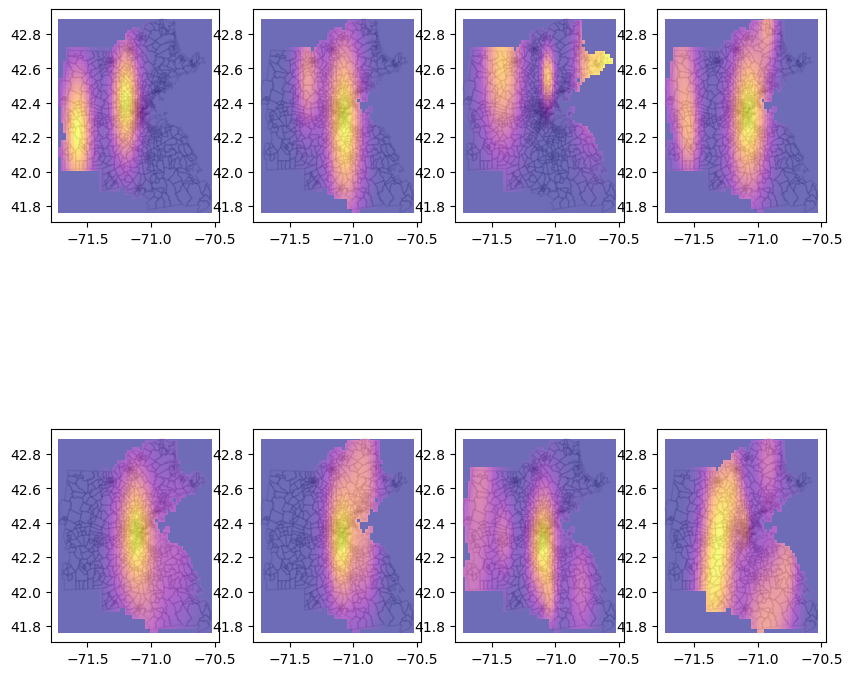

In [20]:
from ipfn import ipfn

with open('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
#print(fitGLM)
k = np.exp(fitGLM['logk'])
alpha =fitGLM['alpha']
beta = fitGLM['gamma']
d0 = fitGLM['1/d0']
list_peaks = [2,3,4,5,6,7,8,10]
InfoConfigurationPolicentricity = {num_peaks: defaultdict() for num_peaks in list_peaks}
total_population = np.sum(grid['population'])
total_flux = np.sum(Tij['number_people'])
fig,ax = plt.subplots(2,4,figsize = (10,10))
axis_idx = 0
for num_peaks in list_peaks:
#    print('Number centers considered: ',num_peaks)
    index_centers = GenerateIndexCenters(grid,num_peaks)
    covariances = SetCovariances(index_centers)
    potential_values = np.zeros(len(grid))
    total_population_center = total_population/len(index_centers)
    new_population = np.ones(len(grid))
    centers = grid.loc[index_centers][['centroidx','centroidy']].to_numpy()
    count_center = 0
    for center in centers:
        for i in range(len(grid)):
            point = np.array([grid['centroidx'][i], grid['centroidy'][i]])
#            print('Coords Projected: ',ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))
#            print('norm: ',np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))**2)
#            print('covariance: ',covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2)
            if grid['is_populated'][i]:
                new_population[i] += total_population_center*np.exp(-(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2/(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))/2
            else:
                new_population[i] = 0
        count_center += 1
#    print('New population: ',new_population.sum())
    # Store Data About Population and Fluxes
    InfoConfigurationPolicentricity[num_peaks]['grid'] = grid.copy()
    InfoConfigurationPolicentricity[num_peaks]['Tij'] = Tij.copy()
    # Normalize Population
    InfoConfigurationPolicentricity[num_peaks]['grid']['new_population'] = new_population
    if axis_idx == 0 or axis_idx == 1:
        print('first axis: ',int((axis_idx+1)/4),' second axis: ',int((axis_idx+1)/2))
        SFO_obj.gdf_polygons.plot(ax = ax[int((axis_idx+1)/4)][int((axis_idx+1)/2)],facecolor = 'none',edgecolor = 'black',alpha = 0.1)    
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[int((axis_idx+1)/4)][int((axis_idx+1)/2)],column = 'new_population',cmap = 'plasma',alpha = 0.6)
    elif axis_idx == 2:
        SFO_obj.gdf_polygons.plot(ax = ax[0][2],facecolor = 'none',edgecolor = 'black',alpha = 0.1)
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[0][2],column = 'new_population',cmap = 'plasma',alpha = 0.6)
    elif axis_idx == 3:
        SFO_obj.gdf_polygons.plot(ax = ax[0][3],facecolor = 'none',edgecolor = 'black',alpha = 0.1)
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[0][3],column = 'new_population',cmap = 'plasma',alpha = 0.6)
    elif axis_idx == 4:
        SFO_obj.gdf_polygons.plot(ax = ax[1][0],facecolor = 'none',edgecolor = 'black',alpha = 0.1)
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[1][0],column = 'new_population',cmap = 'plasma',alpha = 0.6)
    elif axis_idx == 5:
        SFO_obj.gdf_polygons.plot(ax = ax[1][1],facecolor = 'none',edgecolor = 'black',alpha = 0.1)
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[1][1],column = 'new_population',cmap = 'plasma',alpha = 0.6)
    elif axis_idx == 6:
        SFO_obj.gdf_polygons.plot(ax = ax[1][2],facecolor = 'none',edgecolor = 'black',alpha = 0.1)
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[1][2],column = 'new_population',cmap = 'plasma',alpha = 0.6)
    elif axis_idx == 7:
        SFO_obj.gdf_polygons.plot(ax = ax[1][3],facecolor = 'none',edgecolor = 'black',alpha = 0.1)
        InfoConfigurationPolicentricity[num_peaks]['grid'].plot(ax = ax[1][3],column = 'new_population',cmap = 'plasma',alpha = 0.6)


    axis_idx += 1

In [28]:
from ipfn import ipfn
import numpy as np
import pandas as pd

m = np.zeros((2,4,3))
m[0,0,0] = 1
m[0,0,1] = 2
m[0,0,2] = 1
m[0,1,0] = 3
m[0,1,1] = 5
m[0,1,2] = 5
m[0,2,0] = 6
m[0,2,1] = 2
m[0,2,2] = 2
m[0,3,0] = 1
m[0,3,1] = 7
m[0,3,2] = 2
m[1,0,0] = 5
m[1,0,1] = 4
m[1,0,2] = 2
m[1,1,0] = 5
m[1,1,1] = 5
m[1,1,2] = 5
m[1,2,0] = 3
m[1,2,1] = 8
m[1,2,2] = 7
m[1,3,0] = 2
m[1,3,1] = 7
m[1,3,2] = 6
xipp = np.array([52, 48])
xpjp = np.array([20, 30, 35, 15])
xppk = np.array([35, 40, 25])
xijp = np.array([[9, 17, 19, 7], [11, 13, 16, 8]])
xpjk = np.array([[7, 9, 4], [8, 12, 10], [15, 12, 8], [5, 7, 3]])
aggregates = [xipp, xpjp, xppk, xijp, xpjk]
dimensions = [[0], [1], [2], [0, 1], [1, 2]]
IPF = ipfn.ipfn(m, aggregates, dimensions)
m = IPF.iteration()
print(m[0, 0, :].sum())

9
8.999998633525278


distance squared:  5178.745492478886
covariance:  120.25
fraction:  43.066490581945
potential:  1.8568806352964118e-14
distance squared:  5151.747951579669
covariance:  120.25
fraction:  42.84197880731533
potential:  2.324278751926773e-14
distance squared:  5125.732139440436
covariance:  120.25
fraction:  42.62563109721776
potential:  2.8856710910316974e-14
distance squared:  5100.69805606116
covariance:  120.25
fraction:  42.41744745165206
potential:  3.553528780148808e-14
distance squared:  5076.645701441867
covariance:  120.25
fraction:  42.21742787061843
potential:  4.3403748414689515e-14
distance squared:  5053.575075582538
covariance:  120.25
fraction:  42.02557235411674
potential:  5.2583444290978173e-14
distance squared:  5031.4861784831855
covariance:  120.25
fraction:  41.841880902147075
potential:  6.318663295146525e-14
distance squared:  5010.379010143799
covariance:  120.25
fraction:  41.66635351470935
potential:  7.531054480766378e-14
distance squared:  4990.25357056439
c

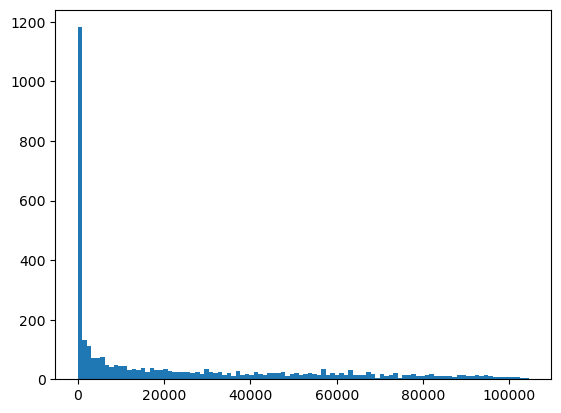

Number pot:  3477


In [48]:
import numpy as np
from scipy.stats import multivariate_normal


## TODO: Decide the number of centers, redistribute the population according to some variance,
##      COMPUTE WITH GRAVITY FLUXES
##      NORMALIZE THEM
##      COMPUTE VECTOR FIELD
##      COMPUTE POTENTIAL
##      CREATE OD FILE IN THE MEAN WHILE
##      SAVE EVERYTHING ON FOLDER WITH POTENTIAL


idx2array = {j*57+ i: [i,j] for j in range(57) for i in range(61)}
# Set the number of peaks
num_peaks = 4
# CENTER
coords_center,center_idx = ExtractCenterByPopulation(grid)
arrayid = idx2array[center_idx]
# CENTER 2
arrayid2 = [arrayid[0] + 10 ,arrayid[1] -7]
coords_center2 = [grid['centroidx'][ExtractKeyFromValue(idx2array,arrayid2)],grid['centroidy'][ExtractKeyFromValue(idx2array,arrayid2)]]
arrayid2 = [arrayid[0] -8 ,arrayid[1] + 10]
coords_center3 = [grid['centroidx'][ExtractKeyFromValue(idx2array,arrayid2)],grid['centroidy'][ExtractKeyFromValue(idx2array,arrayid2)]]
arrayid2 = [arrayid[0] -10 ,arrayid[1] -15]
coords_center4 = [grid['centroidx'][ExtractKeyFromValue(idx2array,arrayid2)],grid['centroidy'][ExtractKeyFromValue(idx2array,arrayid2)]]

# Set the mean and covariance matrix for each peak
means = np.array([[coords_center[0], coords_center[1]], [coords_center2[0], coords_center2[1]],[coords_center3[0], coords_center3[1]],[coords_center4[0], coords_center4[1]]])
covariances = np.array([[[10, 0], [0, 4.5]], [[5, 0], [0, 9]], [[6, 0], [0, 9]], [[7, 0], [0, 8]]])
centers = np.array([coords_center, coords_center2,coords_center3,coords_center4])
# Generate the potential values for each grid
potential_values = np.zeros(len(grid))
count_center = 0
for center in centers:
    for i in range(len(grid)):
        point = np.array([grid['centroidx'][i], grid['centroidy'][i]])
#        print('Coords Projected: ',ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))
#        print('norm: ',np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))**2)
#        print('covariance: ',covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2)
        potential_values[i] += 187652*np.exp(-(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2/(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))/2#multivariate_normal.pdf(grid_center, mean=means[j], cov=covariances[j])
        print('distance squared: ',(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2)
        print('covariance: ',(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))
        print('fraction: ',(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2/(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))        
        print('potential: ',potential_values[i])
    count_center += 1
plt.hist(potential_values, bins=100)
plt.show()
print('Number pot: ',len(potential_values[potential_values>0]))
# Add the new column to the potentialdataframe
PotentialDataframe['new_potential'] = potential_values


# PLOT ABSTRACT CCS

cumulative:  [9.53177159e-05 2.11790336e-04 3.73302218e-04 ... 8.10741155e+07
 8.11784994e+07 8.12829563e+07]
Fstar:  2699
index:  9384423


/tmp/ipykernel_4512/1767893734.py:60: UserWarning: The following kwargs were not used by contour: 'fontsize'
  contour_filled = ax[0][0].tricontourf(grid['geometry'].apply(lambda geom: geom.centroid.x),
/tmp/ipykernel_4512/1767893734.py:65: UserWarning: The following kwargs were not used by contour: 'fontsize'
  contour_lines = ax[0][0].tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x),
/tmp/ipykernel_4512/1767893734.py:79: UserWarning: The following kwargs were not used by contour: 'fontsize'
  contour_filled = ax[0][1].tricontourf(grid['geometry'].apply(lambda geom: geom.centroid.x),
/tmp/ipykernel_4512/1767893734.py:84: UserWarning: The following kwargs were not used by contour: 'fontsize'
  contour_lines = ax[0][1].tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x),
/tmp/ipykernel_4512/1767893734.py:119: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax[1][1].annotate('trantisition polycentrism', xy=(0.5, 

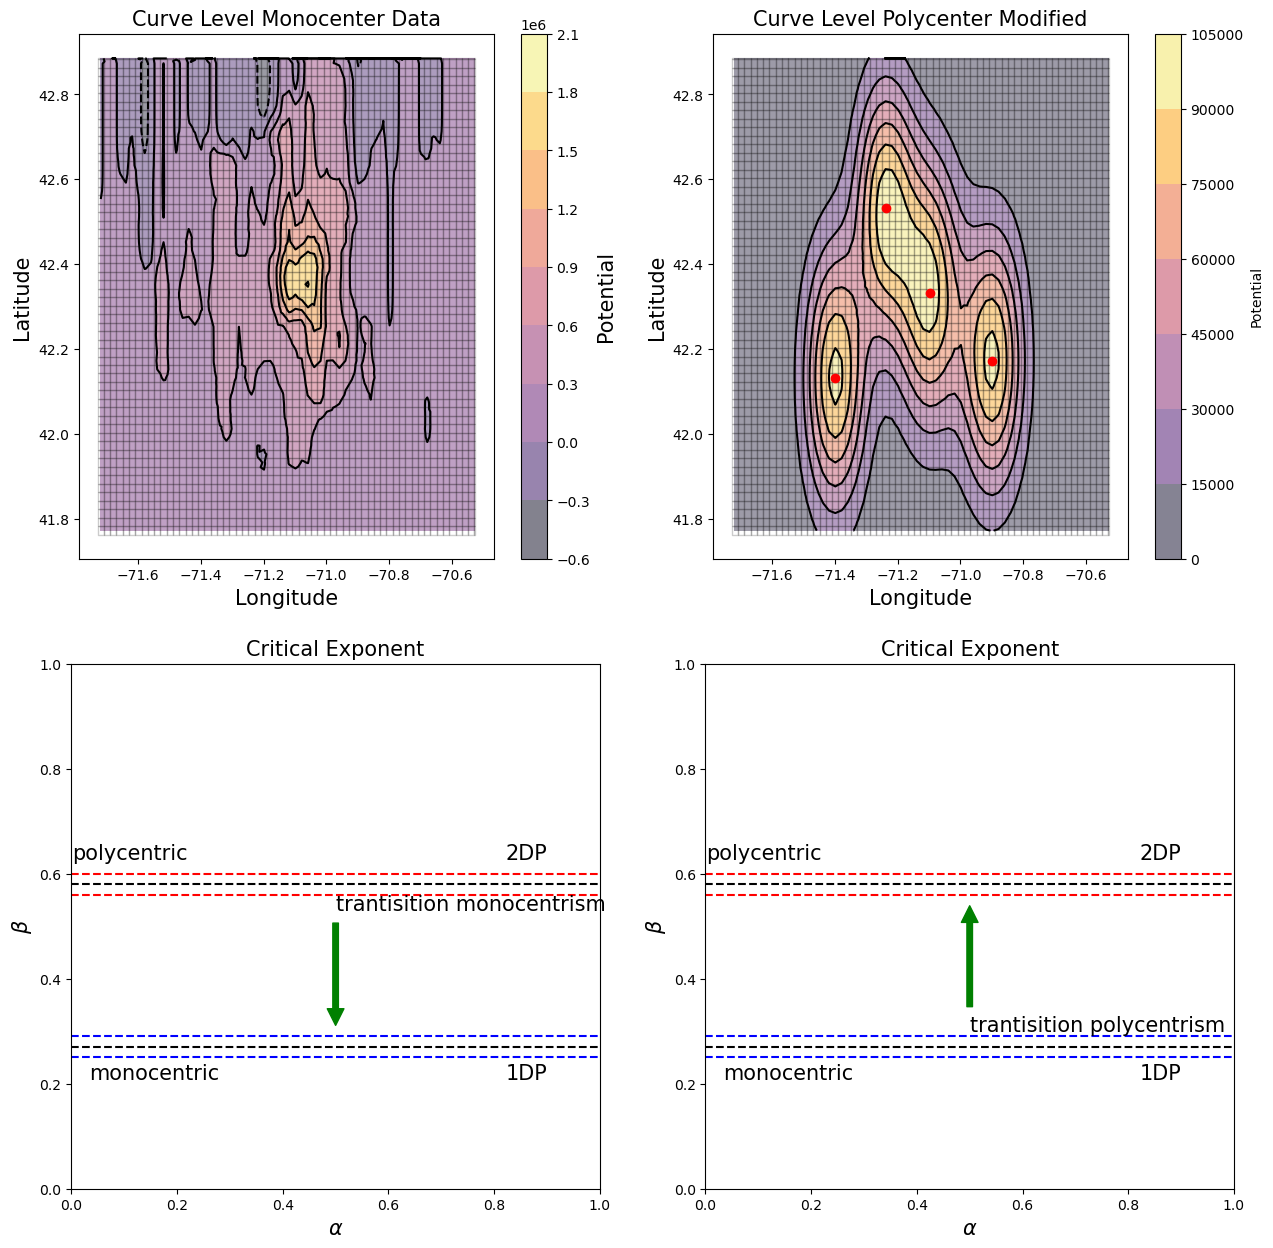

In [73]:
plt.rcParams['text.usetex']=False
def LorenzCenters(potential):
    '''
        Input:
            Potential from grid.
        This function computes the indices of the centers in the linearized grid.
        We are using here the index column and not the double index.
    '''
    # Step 1: Sort the potential and compute the sorting map
    sorted_indices = np.argsort(potential)
    # Step 2: Compute the cumulative distribution
    sorted_potential = potential[sorted_indices]
    cumulative = np.cumsum(sorted_potential)
    # Step 3: Determine the angle and delta index
    print('cumulative: ',cumulative)
    angle = cumulative[-1] - cumulative[-2]
#    print('angle: ',angle)
    Fstar = int(len(cumulative) +1 -cumulative[-1]/angle)
    print('Fstar: ',Fstar)
    print('index: ',int(Fstar*len(cumulative)))
#    plt.show()
    # Step 4: Retrieve the indices based on the delta index and mapping
    result_indices = [sorted_indices[-i] for i in range(len(cumulative) - int(Fstar))]
    cumulative = cumulative/np.sum(sorted_potential)
    return result_indices,angle,cumulative,Fstar

def PlotLorenzCurve(ax,cumulative,Fstar,result_indices,shift = 0.1):
    x = np.arange(len(cumulative))/len(cumulative)
    idxFstar = Fstar #int(Fstar*len(cumulative))
    print('index Fstar: ',Fstar)
    print('cumulative: ',cumulative)
    print('x: ',x)
    print('x[idxFstar]: ',x[idxFstar])
    line1, = ax.plot(x,cumulative,c='black',label='Potential')
    # Plot the straight line to F*
    line2, = ax.plot([x[idxFstar], 1], [0, cumulative[-1]], color='red',label = 'Potential angle')
    ax.plot(x[idxFstar],cumulative[idxFstar],'ro',label='Potential F*')
    if result_indices is not None:
        ax.text(x[Fstar] + shift, 0, f'I* = {x[Fstar]:.2f}', ha='right', va='bottom', color='black')
        ax.text(x[Fstar] + 2*shift , 0.1, f'Centers', ha='right', va='bottom', color='green')
        ax.text(x[Fstar] - 1.5*shift , 0.1, f'No Centers', ha='right', va='bottom', color='yellow')        
        ax.axhline(y=0.05, xmin=0 , xmax=(x[Fstar]), color='yellow', linestyle='--')
        ax.axhline(y=0.05, xmin=x[Fstar], xmax=1, color='green', linestyle='--')
        print(Fstar)
    ax.set_ylim(0)
    ax.set_title('Lorenz Curve Potential')
    ax.set_xlabel('Index sorted grid')
    ax.set_ylabel('Cumulative Potential')
    return line1,line2


#merged_grid['geometry'] = merged_grid['geometry_x']
#merged_grid.plot(column='population', cmap='viridis', legend=True)

fig,ax = plt.subplots(2,2,figsize = (15,15))
grid['potential'] = PotentialDataframe['V_out']

grid['new_potential'] = PotentialDataframe['new_potential']
result_indices,angle,cumulative,Fstar = LorenzCenters(grid['new_potential'].to_numpy())
contour_filled = ax[0][0].tricontourf(grid['geometry'].apply(lambda geom: geom.centroid.x), 
                                 grid['geometry'].apply(lambda geom: geom.centroid.y), 
                                 grid['potential'], cmap='inferno', alpha=0.5,fontsize=15)

# Create contour lines
contour_lines = ax[0][0].tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x), 
                               grid['geometry'].apply(lambda geom: geom.centroid.y), 
                               grid['potential'], colors='black',fontsize=15)

#contour = ax.tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x), 
#                         grid['geometry'].apply(lambda geom: geom.centroid.y), 
#                         grid['potential'], alpha=1, cmap='inferno')

cbar = plt.colorbar(contour_filled)
cbar.set_label('Potential',fontsize=15)
ax[0][0].set_title('Curve Level Monocenter Data',fontsize=15)
ax[0][0].set_xlabel('Longitude',fontsize=15)
ax[0][0].set_ylabel('Latitude',fontsize=15)

contour_filled = ax[0][1].tricontourf(grid['geometry'].apply(lambda geom: geom.centroid.x), 
                                 grid['geometry'].apply(lambda geom: geom.centroid.y), 
                                 grid['new_potential'], cmap='inferno', alpha=0.5,fontsize=15)

# Create contour lines
contour_lines = ax[0][1].tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x), 
                               grid['geometry'].apply(lambda geom: geom.centroid.y), 
                               grid['new_potential'], colors='black',fontsize=15)

grid.plot(ax=ax[0][0], color='white', edgecolor='black',alpha = 0.2)
grid.plot(ax=ax[0][1], color='white', edgecolor='black',alpha = 0.2)

#contour = ax.tricontour(grid['geometry'].apply(lambda geom: geom.centroid.x), 
#                         grid['geometry'].apply(lambda geom: geom.centroid.y), 
#                         grid['potential'], alpha=1, cmap='inferno')

cbar = plt.colorbar(contour_filled)
cbar.set_label('Potential')
ax[0][1].set_title('Curve Level Polycenter Modified',fontsize=15)
ax[0][1].set_xlabel('Longitude',fontsize=15)
ax[0][1].set_ylabel('Latitude',fontsize=15)
ax[0][1].scatter(means[0][0],means[0][1],color = 'red')
ax[0][1].scatter(means[1][0],means[1][1],color = 'red')
ax[0][1].scatter(means[2][0],means[2][1],color = 'red')
ax[0][1].scatter(means[3][0],means[3][1],color = 'red')
x = np.linspace(0,1,len(cumulative))
y = np.linspace(0,1,len(cumulative))
#result_indices,angle,cumulative,Fstar = LorenzCenters(PotentialDataframe.loc[PotentialDataframe['V_out']>0]['V_out'].to_numpy())
#PlotLorenzCurve(ax[1][0],cumulative,Fstar,result_indices,shift = 0.1)
#result_indices,angle,cumulative,Fstar = LorenzCenters(PotentialDataframe.loc[PotentialDataframe['new_potential']>0]['new_potential'].to_numpy())
#PlotLorenzCurve(ax[1][1],cumulative,Fstar,result_indices,shift = 0.1)
ax[1][1].set_title('Critical Exponent',fontsize=15)
ax[1][1].axhline(y=0.58, xmin=0 , xmax=1, color='black', linestyle='--')
ax[1][1].axhline(y=0.6, xmin=0 , xmax=1, color='red', linestyle='--')
ax[1][1].axhline(y=0.56, xmin=0 , xmax=1, color='red', linestyle='--')
ax[1][1].set_ylim(0,1)
ax[1][1].set_xlim(0,1)
ax[1][1].text(0.22,0.62,'polycentric', ha='right', va='bottom', color='black',fontsize=15)
ax[1][1].text(0.9,0.62,'2DP', ha='right', va='bottom', color='black',fontsize=15)

ax[1][1].annotate('trantisition polycentrism', xy=(0.5, 0.55), xytext=(0.5, 0.3),
            arrowprops=dict(facecolor='black', shrink=0.05,color = 'green'),fontsize=15)
ax[1][1].axhline(y=0.27, xmin=0 , xmax=1, color='black', linestyle='--')
ax[1][1].axhline(y=0.25, xmin=0 , xmax=1, color='blue', linestyle='--')
ax[1][1].axhline(y=0.29, xmin=0 , xmax=1, color='blue', linestyle='--')
ax[1][1].text(0.28,0.2,'monocentric', ha='right', va='bottom', color='black',fontsize=15)
ax[1][1].text(0.9,0.2,'1DP', ha='right', va='bottom', color='black',fontsize=15)

#ax[2][1].fill_between(x,y, where=((y >= 0.56) & (y <= 0.60)), color='blue', alpha=0.3)
ax[1][1].set_xlabel(r'$\alpha$',fontsize=15)
ax[1][1].set_ylabel(r'$\beta$',fontsize=15)
ax[1][0].set_title('Critical Exponent',fontsize=15)
ax[1][0].axhline(y=0.27, xmin=0 , xmax=1, color='black', linestyle='--')
ax[1][0].axhline(y=0.25, xmin=0 , xmax=1, color='blue', linestyle='--')
ax[1][0].axhline(y=0.29, xmin=0 , xmax=1, color='blue', linestyle='--')
ax[1][0].text(0.28,0.2,'monocentric', ha='right', va='bottom', color='black',fontsize=15)
ax[1][0].text(0.9,0.2,'1DP', ha='right', va='bottom', color='black',fontsize=15)
ax[1][0].axhline(y=0.58, xmin=0 , xmax=1, color='black', linestyle='--')
ax[1][0].axhline(y=0.6, xmin=0 , xmax=1, color='red', linestyle='--')
ax[1][0].axhline(y=0.56, xmin=0 , xmax=1, color='red', linestyle='--')
ax[1][0].text(0.22,0.62,'polycentric', ha='right', va='bottom', color='black',fontsize=15)
ax[1][0].text(0.9,0.62,'2DP', ha='right', va='bottom', color='black',fontsize=15)
ax[1][0].annotate('trantisition monocentrism', xy=(0.5, 0.3), xytext=(0.5, 0.53),
            arrowprops=dict(facecolor='black', shrink=0.05,color = 'green'),fontsize=15)


ax[1][0].set_ylim(0,1)
ax[1][0].set_xlim(0,1)
#ax[2][0].fill_between(x,y, where=((y >= 0.26) & (y <= 0.29)), color='blue', alpha=0.3)
ax[1][0].set_xlabel(r'$\alpha$',fontsize=15)
ax[1][0].set_ylabel(r'$\beta$',fontsize=15)
ax[1][0].set_title('Critical Exponent',fontsize=15)

plt.savefig('/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/data/carto/BOS/potential/curve_levelError.png',dpi = 200)

#plt.savefig('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/curve_levelError.png')

In [ ]:
from tqdm import tqdm
from Polycentrism import *
SumPot = np.sum(PotentialDataframe['V_out']) 
NumGridEdge = grid[grid['relation_to_line']=='edge'].shape[0]
IndexEdge = PotentialDataframe[PotentialDataframe['V_out']>0]['index'].values

distance_vector,potential_vector = PrepareJitCompiledComputeV(df_distance,GetIndexEdgePolygon(grid),SumPot,NumGridEdge,PotentialDataframe,case = 'Vmax')
Vmax = ComputeJitV(distance_vector,potential_vector)
distance_vector,potential_vector = PrepareJitCompiledComputeV(df_distance,GetIndexEdgePolygon(grid),SumPot,NumGridEdge,PotentialDataframe,case = 'V')
V = ComputeJitV(distance_vector,potential_vector)
PI = ComputePI(V,Vmax)
print('PI: ',PI)


# MODIFY POLYCENTRICITY

##### 

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal


def ExtractCenterByPopulation(grid):
    assert 'population' in grid.columns
    population = grid['population'].copy()
    center_idx = np.argmax(population)
    coords_center = np.array([grid['centroidx'][center_idx],grid['centroidy'][center_idx]]) 
    return coords_center,center_idx

def ExtractKeyFromValue(dict_,value):
    for key, val in dict_.items():
        if val == value:
            return key


idx2array = {j*57+ i: [i,j] for j in range(57) for i in range(61)}
# Set the number of peaks
num_peaks = 4
# CENTER
coords_center,center_idx = ExtractCenterByPopulation(grid)
arrayid = idx2array[center_idx]
# CENTER 2
arrayid2 = [arrayid[0] + 10 ,arrayid[1] -7]
coords_center2 = [grid['centroidx'][ExtractKeyFromValue(idx2array,arrayid2)],grid['centroidy'][ExtractKeyFromValue(idx2array,arrayid2)]]
arrayid2 = [arrayid[0] -8 ,arrayid[1] + 10]
coords_center3 = [grid['centroidx'][ExtractKeyFromValue(idx2array,arrayid2)],grid['centroidy'][ExtractKeyFromValue(idx2array,arrayid2)]]
arrayid2 = [arrayid[0] -10 ,arrayid[1] -15]
coords_center4 = [grid['centroidx'][ExtractKeyFromValue(idx2array,arrayid2)],grid['centroidy'][ExtractKeyFromValue(idx2array,arrayid2)]]

# Set the mean and covariance matrix for each peak
means = np.array([[coords_center[0], coords_center[1]], [coords_center2[0], coords_center2[1]],[coords_center3[0], coords_center3[1]],[coords_center4[0], coords_center4[1]]])
covariances = np.array([[[10, 0], [0, 4.5]], [[5, 0], [0, 9]], [[6, 0], [0, 9]], [[7, 0], [0, 8]]])
centers = np.array([coords_center, coords_center2,coords_center3,coords_center4])
# Generate the potential values for each grid
potential_values = np.zeros(len(grid))
count_center = 0
for center in centers:
    for i in range(len(grid)):
        point = np.array([grid['centroidx'][i], grid['centroidy'][i]])
#        print('Coords Projected: ',ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))
#        print('norm: ',np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))**2)
#        print('covariance: ',covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2)
        potential_values[i] += 187652*np.exp(-(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2/(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))/2#multivariate_normal.pdf(grid_center, mean=means[j], cov=covariances[j])
        print('distance squared: ',(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2)
        print('covariance: ',(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))
        print('fraction: ',(np.linalg.norm(ProjCoordsTangentSpace(center[0],center[1],point[0],point[1]))/(10**3))**2/(covariances[count_center][0][0]**2 + covariances[count_center][1][1]**2))        
        print('potential: ',potential_values[i])
    count_center += 1
plt.hist(potential_values, bins=100)
plt.show()
print('Number pot: ',len(potential_values[potential_values>0]))
# Add the new column to the potentialdataframe
PotentialDataframe['new_potential'] = potential_values


In [ ]:

def ComputeVectorFieldModified(Tij,df_distance):
    Tij['vector_flux'] = df_distance['dir_vector'].apply(lambda x: parse_dir_vector(x) ) * Tij['number_people']

    # Create VectorField DataFrame
    VectorField = pd.DataFrame(index=Tij['(i,j)D'].unique(), columns=['(i,j)', 'Ti', 'Tj'])
    Tj_values = Tij.groupby('(i,j)D')['vector_flux'].sum()
    VectorField['Tj'] = Tj_values

    # Calculate 'Ti' values
    Ti_values = Tij.groupby('(i,j)O')['vector_flux'].sum()
    VectorField['Ti'] = Ti_values
    VectorField['index'] = VectorField.index
    VectorField['(i,j)'] = VectorField['index']
    VectorField['index'] = VectorField.index
    VectorField.reset_index(inplace=True)
    return VectorField

def fill_zeros_with_fit(vector):
    # Find indices of non-zero values
    non_zero_indices = np.where(vector != 0)[0]
    
    # Use non-zero indices to fit values
    fitted_values = np.interp(np.arange(len(vector)), non_zero_indices, vector[non_zero_indices])
    
    # Replace zeros with fitted values
    filled_vector = np.where(vector == 0, fitted_values, vector)
    
    return filled_vector

def IdxGrid2IdxBin(pop, idxgrid, bins):
    mask = [(pop[idxgrid] >= bins[j]) and (pop[idxgrid] <= bins[j + 1]) for j in range(len(bins) - 1)]
    indices = [j for j, m in enumerate(mask) if m]
    return indices

def UpdatePolycentricPop(population,index,index1,NCell2DividePop):
    population[index1] += population[index]/NCell2DividePop  
    population[index] = population[index]/NCell2DividePop
    return population

def UpdateMonocentricPop(population,index,index1):
    population[index1] += population[index]
    population[index] = 0
    return population

def ReassignPopulationRandomly(grid, m0, r0, N, transform_toward = 'monocentric',geometricl_influence = False):
    '''
        Input:
            grid: Grid with info about population and distance
            m0: Parameter, 66% of grid, have mass in the interval [0,m0]
            r0: Parameter, 66% of grid, have distance in the interval [0,r0]
            N: Number of repetitions 
            transfrom_toward: 'monocentric', 'policentric'
        Output:
            population: np.array Population Modified 
            evolution_mean: np.array -> Since during the population is redestributed then the mean changes as the number of grids that have population changes
            evolution_number_centers: np.array -> Number of centers that change
            population_moved: float: Total Population has moved after the simulation
            evolution_population_moved: np.array How much population is moved in the ITERATIONS
        This function reassign population according to ModifyPop principles.
        Takes the probability to reassign depending on the distance from the center.

    '''    
    evolution_mean = []
    evolution_number_centers = []
    fraction_times_change_pop = 0
    population_moved = 0
    evolution_population_moved = []
    # POPULATION
    population = grid['population'].copy()
    center_idx = np.argmax(population)
    coords_center = np.array([grid['centroidx'][center_idx],grid['centroidy'][center_idx]]) 
    indices = np.where(population > 0)[0]  # Step 1
    n,bins = np.histogram(population,500)
    # GET POPULATION DISTRIBUTION
    p = n/np.sum(n)
    p1 = fill_zeros_with_fit(p)
    for _ in range(N):
        # CONSIDER JUST THE GRIDS WITH POPULATION>0 
        indices = np.where(population > 0)[0]  
        # PICK RANDOMLY THE GRID WHOSE POPULATION WILL BE SET TO 0 if satisfy the right criterium
        index = np.random.choice(indices)
        # FIND THE BIN in which it lies
        # NOTE: Since index is in indices I must look at population[indices] -> filtered with just populated grids 
        assert index in indices
        binidx = IdxGrid2IdxBin(population[indices], index, bins)[0]

        # TAKE PROBABILITY OF THE MEASURED POPULATION 
        pl_value = p1[binidx]
        # TAKE THE FAKE DISTRIBUTION
        exp_value = np.exp(-bins[binidx]/m0)

        # EVOLUTION AVERAGE & NUMBER CENTERS
        # NOTE: DEBUGGING PORPOUSES -> Takes track of the population distribution
        evolution_mean.append(np.mean(population[indices]))
        evolution_number_centers.append(len(indices))
        if transform_toward == 'monocentric':
            # REASSIGN THE 'LOW POPULATED GRIDS'
            if pl_value > exp_value:  
#            print('Mass extracted: ',mass_extracted)
#            print('Expo prob: ',exp_value)
#            print('Power Law prob: ',pl_value)
#            print('Population going 0: ',population[index])
                fraction_times_change_pop +=1     
                # CHOOSE THE REASSIGNED GRID AMONG POPULATED GRIDS       
                index1 = np.random.choice(indices)
                while(population[index1]==0):
                    index1 = np.random.choice(indices)
                    # NOTE: IMPOSE that the reassignment to stay close to the center.
                    if geometricl_influence:
                        while(np.exp(-r/r0)>p):
                            index1 = np.random.choice(indices)
                            center_extracted = np.array([grid['centroidx'][index1],grid['centroidy'][index1]])
                            r = ProjCoordsTangentSpace(coords_center[0],coords_center[1],center_extracted[0],center_extracted[1])
                        population_moved += population[index]
                        evolution_population_moved.append(population_moved)
                        population = UpdateMonocentricPop(population,index,index1)                    
                    else:
                        population_moved += population[index]
                        evolution_population_moved.append(population_moved)
                        population = UpdateMonocentricPop(population,index,index1)
#            print('Population increased: ',population[index1])
            else:
                evolution_population_moved.append(population_moved)
        if transform_toward == 'polycentric':
            # REASSIGN THE 'LOW POPULATED GRIDS'
            if pl_value < exp_value:  
                fraction_times_change_pop +=1     
                # CHOOSE THE REASSIGNED GRID AMONG POPULATED GRIDS       
                index1 = np.random.choice(indices)
                # AVG POPULATION TO CONTROL HOW MANY POP TO SPREAD TO
                avg_pop = np.mean(population[indices])
                NCell2DividePop= int(population[index]/avg_pop)
                # DIVIDE THE POPULATION IN NCell2DividePop Parts so that the distribution will be more spreaded
                for Cell in range(NCell2DividePop):
                    while(population[index1]==0):
                        index1 = np.random.choice(indices)
                        # NOTE: IMPOSE that the reassignment to stay close to the center.
                        if geometricl_influence:
                            while(np.exp(-r/r0)>p):
                                index1 = np.random.choice(indices)
                                center_extracted = np.array([grid['centroidx'][index1],grid['centroidy'][index1]])
                                r = ProjCoordsTangentSpace(coords_center[0],coords_center[1],center_extracted[0],center_extracted[1])
                            population_moved += population[index]/NCell2DividePop
                            evolution_population_moved.append(population_moved)
                            population = UpdatePolycentricPop(population,index,index1,NCell2DividePop)
                        else:
                            # MOVE THE FRACTION OF PEOPLE THAT ARE MORE THEN AVERAGE TOWARD AVERAGE
                            population_moved += population[index]/NCell2DividePop
                            evolution_population_moved.append(population_moved)
                            population = UpdatePolycentricPop(population,index,index1,NCell2DividePop)

    #            print('Population increased: ',population[index1])
            else:
                evolution_population_moved.append(population_moved)
            
    print('Fraction Changed: ',fraction_times_change_pop/N)
    print('Total Grids Changed: ',fraction_times_change_pop)
    print('Total number Population Moved: ',population_moved)
    return population,evolution_mean,evolution_number_centers,population_moved,evolution_population_moved


3010.0008695535003
16254.004695588903
28494.674898439804


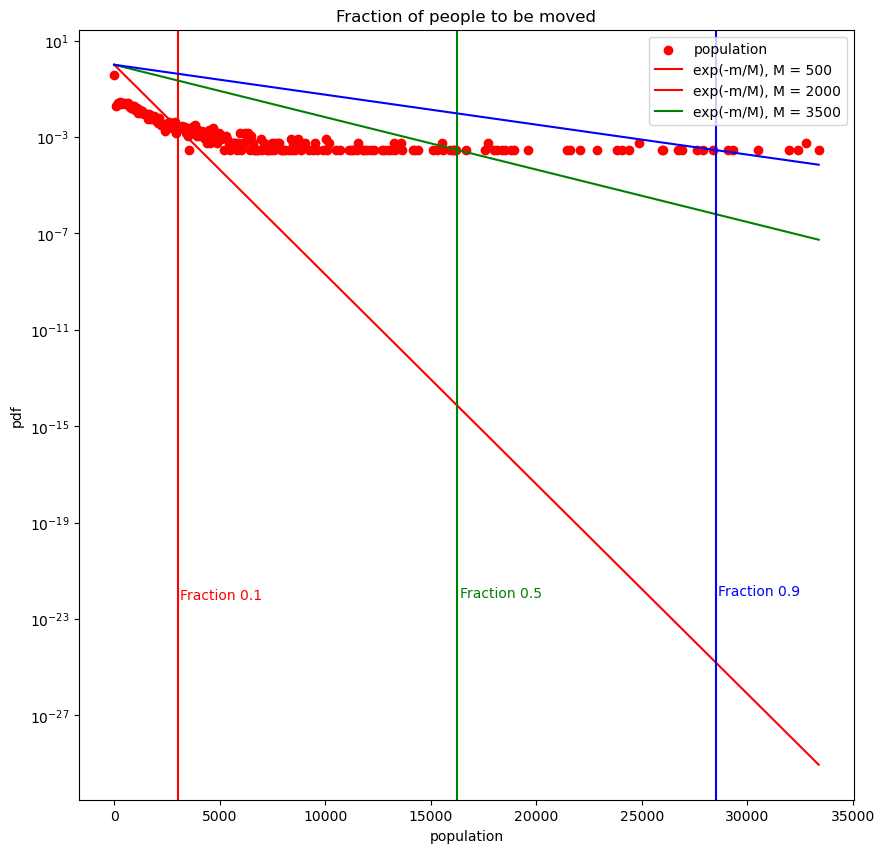

Final 0.0015763106331130763


In [ ]:
def PlotComparisonMass2ExpDistr(population,a,partition_population = 500,shift = 2000):
    '''
        Given a population distribution and exponential characteristics:
            - Determines the fraction of grids that have less population then 
    '''
    n,bins = np.histogram(population,partition_population)
    x = -np.linspace(bins[0],bins[-1],partition_population)

n,bins = np.histogram(grid['population'],500)
shift = 2000
x = -np.linspace(bins[0],bins[-1],500)
deltax = bins[1] - bins[0]
expa = []
EvolutionExpNumber = 3
colordict = colors = ["red","green","blue","yellow"]

legend = ['population']
p = n/np.sum(n)
p1 = fill_zeros_with_fit(p)
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.scatter(bins[:-1],p,color = 'red')
i = 0
for a in np.linspace(500,3500,EvolutionExpNumber):
    Aa = 1/(1-np.exp(-deltax/a))
    exp_ = np.exp(x/a)
    abs_diff = np.abs(exp_ - p1)
#    print('exp: ',exp_)
#    print('Diff: ',abs_diff)

    # Find the index of the minimum difference
    min_diff_index = np.argmin(abs_diff)
#    print('A: ',Aa,' deltax: ',deltax/a,' sum(exp): ',np.sum(exp_),' Error approx: ',np.sum(exp_)-Aa)
    # GET POPULATION DISTRIBUTION
    ax.plot(bins[:-1],exp_,label = a,color = colors[i])#/(bins[-1]-bins[0])
    ax.axvline(bins[min_diff_index],color = colors[i])
    plt.text(bins[min_diff_index] + 2*shift , (i+5)*(10**(-23)), f'Fraction {round(bins[min_diff_index]/bins[-1],1)}', ha='right', va='bottom', color=colors[i])
#    plt.axhline(y=(i+3)*(10**(-23)), xmin=0, xmax=bins[min_diff_index], color=colors[i], linestyle='--')

    print(bins[min_diff_index])
    legend.append('exp(-m/M), M = {}'.format(int(a)))
    i += 1
plt.legend(legend)    
plt.yscale('log')
ax.set_xlabel('population')
ax.set_ylabel('pdf')
ax.set_title('Fraction of people to be moved')
plt.savefig('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/FractionMoved.png',dpi = 200)
plt.show()
print('Final',np.sum(exp_)/(bins[-1]-bins[0]))

#plt.scatter(np.linspace(1,bins[-1],EvolutionExpNumber),expa)
#plt.xscale('log')
#plt.yscale('log')
#plt.show()


In [ ]:
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitVespignani.json','r')as f:
    fitGLM = json.load(f)
#with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitPlMass.json','r') as f:
#    fitplM = json.load(f)

In [ ]:
fractions = np.linspace(1,15,15)
r0 = 10
N = 2000 
for fraction in fractions:
    m01 = m0 + m0*fraction
    population, evolution_mean,evolution_number_centers,population_moved,evolution_population_moved = ReassignPopulationRandomly(grid, m0, r0, N) 
#    ReassignPopulationRandomly(grid, m0, fitplM['A'],fitplM['b'], 2000)
    PopChanged, PopChangedBins = np.histogram(population,40)
    PopChanged = PopChanged/np.sum(PopChanged)
    grid['changed_population'] = population
    fig,ax = plt.subplots(1,1,figsize = (12,12))
    SFO_obj.gdf_polygons.plot(ax=ax, color='white', edgecolor='black')
    grid_plot = grid.plot(column='changed_population', cmap='viridis', edgecolor='black', alpha=0.3, legend=True, ax=ax)
    ax.set_title('Population Boston Changed')
    plt.savefig(os.path.join(dir_grid,'populationBoston.png'),dpi = 200)    
    fig,ax = plt.subplots(1,1,figsize = (10,10))
    ax.scatter(PopDataBins[:-1],PopData,color = 'red',label = 'Data')
    ax.plot(PopBins,PopExpo,color = 'blue',label = 'Expo')
    ax.scatter(PopChangedBins[:-1],PopChanged,color = 'yellow', label = 'Changed Population')
    ax.set_xlabel('Population')
    ax.set_ylabel('pdf')
    ax.set_yscale('log')
    ax.set_title('{}'.format(m01))
    plt.show()

    fig,ax = plt.subplots(1,1,figsize = (10,10))
    ax.plot(np.arange(len(evolution_mean)),evolution_mean,color = 'red',label = 'Mean')
    ax.plot(np.arange(len(evolution_number_centers)),evolution_number_centers,color = 'blue',label = 'Number Grids with People')
    ax.plot(np.arange(len(evolution_number_centers)),evolution_population_moved,color = 'yellow',label = 'Population Moved')
    ax.set_title('{}'.format(m01))
    ax.set_xlabel('Iteration')
    ax.set_yscale('log')
    ax.legend(['Mean Population','Number of Grids with People','Population Moved'])
    plt.show()


# GET Vec Field & Pot

In [ ]:
ComputeInitPotential = True
ComputeInitVF = True
if ComputeInitVF:
    VectorField = GetVectorField(Tij,df_distance)
    VectorFieldDir = os.path.join(TRAFFIC_DIR,'data','carto',name,'grid',str(grid_size))
    SaveVectorField(VectorField,VectorFieldDir)

if ComputeInitPotential:
    lattice = GetPotentialLattice(lattice,VectorField)
    lattice = SmoothPotential(lattice)
    PotentialDataframe = ConvertLattice2PotentialDataframe(lattice)
    PotentialDataframe = CompletePotentialDataFrame(VectorField,grid,PotentialDataframe)
    SavePotentialDataframe(PotentialDataframe,dir_grid)


# MODIFY  

In [ ]:
## TODO: Modify Population -> Compute Fluxes -> Get Vector Field -> Compute Modified Potential -> Compute Lorenz -> Compute OD

with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/potential/FitFluxesParameters.json','r')as f:
    fitGLM = json.load(f)
p0 = fraction

Population = ModifyPop(Population)
Tij_modified = ComputeFluxesModifiedPopulation(Population) 
VectorField = ComputeVectorFieldModified(Tij,df_distance)
Potential = ComputePotentialModified(VectorField)

p = ComputeLorenzCurve(Potential)
OD_DemandFromFluxes()

# MODIFIED OD CREATION

In [ ]:
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/origindest2grid.json','r') as f:
    OD2grid = json.load(f)

with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/grid/0.02/grid2origindest.json','r') as f:
    grid2OD = json.load(f)
with open('/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/osmid2idx.json') as f:
    osmid2index = json.load(f)

def CumulativeODFromGrid(O_vector,D_vector,OD_vector,osmid2index,grid2OD,start,multiplicative_factor,seconds_in_minute):
    total_number_people_considered = 0
    total_number_people_not_considered = 0
    count_line = 0
    users_id = []
    time_ = []
    origins = []
    destinations = []
    osmid_origin = []
    osmid_destination = []
    print('number of couples of origin-destination: ',len(O_vector))
    for i in range(len(O_vector)):
        origin = O_vector[i]
        destination = D_vector[i]
        number_people = OD_vector[i]
        bin_width = 1                        
        if number_people > 0:
            iterations = multiplicative_factor*number_people/bin_width   
            time_increment = 1/iterations
            for it in range(int(iterations)):
                try:
                    Originbigger0 = len(grid2OD[origin])>0
                except KeyError:
                    total_number_people_not_considered += number_people
                    break
                try:
                    Destinationbigger0 = len(grid2OD[destination])>0
                except KeyError:
                    total_number_people_not_considered += number_people
                    break
                if  Originbigger0 and Destinationbigger0:
                    users_id.append(count_line)
                    t = start*(seconds_in_minute**2) + it*time_increment*seconds_in_minute**2
                    time_.append(t) # TIME IN HOURS
                    i = np.random.randint(0,len(grid2OD[origin]))
                    try:
                        origins.append(osmid2index[grid2OD[origin][i]])
                    except KeyError:
                        total_number_people_not_considered += number_people
                        raise KeyError('KeyError Polygon 2 OD: origin {0} i {1}'.format(origin,i))
                    j = np.random.randint(0,len(grid2OD[destination]))                        
                    try:
                        destinations.append(osmid2index[grid2OD[destination][j]])
                    except KeyError:
                        total_number_people_not_considered += number_people
                        raise KeyError('KeyError Polygon 2 OD: destination {0} j {1}'.format(origin,i))
                    osmid_origin.append(grid2OD[origin][i])
                    osmid_destination.append(grid2OD[destination][j])
                    ## FILLING ORIGIN DESTINATION GRID ACCORDING TO THE ORIGIN DESTINATION NODES
                    count_line += 1
                    total_number_people_considered += 1
    print('total_number_people_considered: ',total_number_people_considered)
    print('total_number_people_not_considered: ',total_number_people_not_considered)
    print('ratio: ',total_number_people_considered/(total_number_people_considered+total_number_people_not_considered))
    return users_id,time_,origins,destinations,osmid_origin,osmid_destination

def OD_from_T_Modified(Tij_modified,
                       CityName2RminRmax,
                       NameCity,
                       osmid2index,
                       grid2OD,
                       p,
                       save_dir_local,
                       start = 7,
                       end = 8
                       ):
    ROutput = []
    # NOTE: ADD HERE THE POSSIBILITY OF HAVING OD FROM POTENTIAL CONSIDERATIONS
    O_vector = Tij_modified['origin']
    D_vector = Tij_modified['destination']
    OD_vector = Tij_modified['number_people']
    # START TAB
    R = np.sum(OD_vector)/3600 # R is the number of people that move in one second (that is the time interval for the evolution )
    Rmin = CityName2RminRmax[NameCity][0]
    Rmax = CityName2RminRmax[NameCity][1]
    spacing = (Rmax/R - Rmin/R)/20
    for multiplicative_factor in np.arange(Rmin/R,Rmax/R,spacing):
        R = np.sum(OD_vector)/3600 
        if os.path.isfile(os.path.join(save_dir_local,'OD','{0}_oddemand_{1}_{2}_R_{3}.csv'.format(NameCity,start,end,int(multiplicative_factor*R)))):
            cprint(os.path.join(save_dir_local,'OD','{0}_oddemand_{1}_{2}_R_{3}.csv'.format(NameCity,start,end,int(multiplicative_factor*R))),'cyan')
            ROutput.append(int(multiplicative_factor*R))
            continue
        else:
            cprint('COMPUTING {}'.format(os.path.join(save_dir_local,'OD','{0}_oddemand_{1}_{2}_R_{3}.csv'.format(NameCity,start,end,int(multiplicative_factor*R)))),'cyan')
            users_id,time_,origins,destinations,osmid_origin,osmid_destination = CumulativeODFromGrid(O_vector,D_vector,OD_vector,osmid2index,grid2OD,start,multiplicative_factor,60)
            df1 = pd.DataFrame({
                'SAMPN':users_id,
                'PERNO':users_id,
                'origin_osmid':osmid_origin,
                'destination_osmid':osmid_destination,
                'dep_time':time_,
                'origin':origins,
                'destination':destinations,
                })
            print('df1:\n',df1.head())
            R = multiplicative_factor*R
            ROutput.append(int(R))
            df1.to_csv('')
    
